In [1]:
import os
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  # noqa
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import trange

from experiment_utils import compute_jemmig
from kgi import apply_kgi_to_model

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

# Data

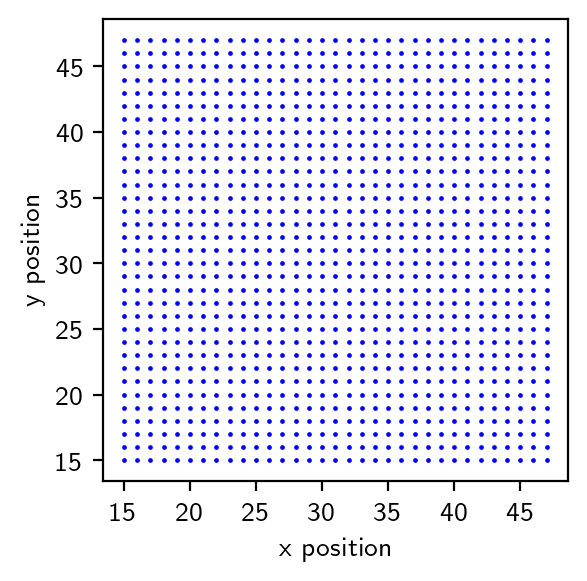

In [3]:
class XYC(Dataset):
    """ dataset """

    def __init__(self, path_dir):
        self.data_path = os.path.join(path_dir, "xy.npz")
        self.data_zip = np.load(self.data_path)
        self.data = self.data_zip['imgs']
        self.labels = self.data_zip['labs']

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.labels[idx]
        sample = torch.from_numpy(np.expand_dims(sample, axis=0))
        label = torch.from_numpy(np.expand_dims(label, axis=0))
        sample = {'x': sample,
                  'y': label}
        return sample


train_x = XYC('datasets')
test_x = XYC('datasets')
true_labels = train_x.labels

plt.figure(dpi=200, figsize=(3, 3))
plt.scatter(true_labels[:, 0], true_labels[:, 1], c='b', s=.5)
plt.xticks(np.arange(15, 47, 5), np.arange(15, 47, 5))
plt.yticks(np.arange(15, 47, 5), np.arange(15, 47, 5))
plt.xlabel("x position")
plt.ylabel("y position")
plt.show()

### Visualize the problem

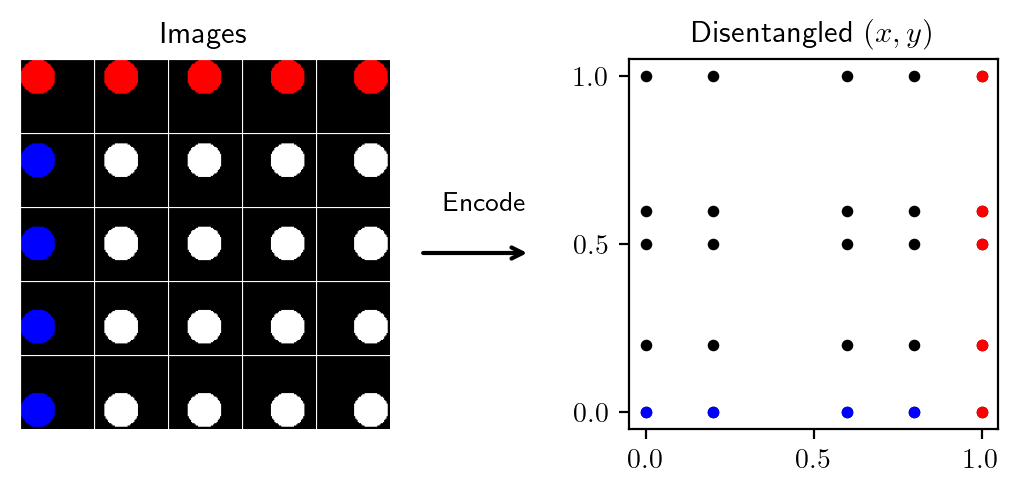

In [4]:
n = 5
img = torch.zeros(64 * n, 64 * n, 3)
for i in range(n):
    for j in range(n):
        delta = 32 // (n - 1)
        target = train_x[j * delta * 33 + i * delta]["x"][0].clone()
        if i == 0:
            img[i * 64:i * 64 + 64, j * 64:j * 64 + 64, 0] = target
        elif j == 0:
            img[i * 64:i * 64 + 64, j * 64:j * 64 + 64, 2] = target
        else:
            img[i * 64:i * 64 + 64, j * 64:j * 64 + 64, :] = target[:, :, None]
        img[i * 64:i * 64 + 64, j * 64:j * 64 + 1, :] = 1
        img[i * 64:i * 64 + 1, j * 64:j * 64 + 64, :] = 1
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(6 * 1.2, 2 * 1.2))
axes[0].imshow(img, cmap='gray')
axes[0].axis("off")
axes[1].scatter(*np.meshgrid([0, 0.2, 0.6, 0.8, 1],
                             [0, 0.2, 0.5, 0.6, 1]), c='k', s=10)
axes[1].scatter(*np.meshgrid([1], [0, 0.2, 0.5, 0.6, 1]), c='r', s=10)
axes[1].scatter(*np.meshgrid([0, 0.2, 0.6, 0.8], [0]), c='b', s=10)
axes[1].set_yticks(torch.linspace(0, 1, 3))
axes[1].set_aspect(1.)
axes[0].set_title("Images", fontsize=11)
axes[1].set_title("Disentangled $(x,y)$", fontsize=11)
plt.annotate("", xy=(0.37, 0.5), xytext=(0.29, 0.5),
             xycoords='figure fraction', textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->", lw=1.5))
plt.text(-.6, .6, "Encode")
plt.savefig("figs/disent_problem.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

# Training

In [5]:
class VAE(nn.Module):
    """ VAE model """

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_seq = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
        )

        self.fc_mu = nn.Linear(128, self.latent_dim)
        self.fc_logvar = nn.Linear(128, self.latent_dim)

        self.decoder_seq = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 64 * 64),
            nn.Sigmoid()
        )

    def sample(self, z=None):
        samples = self.decode(z)
        return samples

    def reconstr(self, x):
        mu, _ = self.encode(x)
        reconstr = self.decode(mu)
        return reconstr

    def encode(self, x):
        x = self.encoder_seq(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def latent(self, x):
        z, _ = self.encode(x)
        return z

    def decode(self, x):
        x = self.decoder_seq(x)
        return x

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        c = self.reparameterize(mu, logvar)
        reconstr = self.decode(c)
        return [reconstr, mu, logvar]

In [6]:
device_ = "cuda" if torch.cuda.is_available() else "cpu"
random_state = np.random.RandomState(1234)
seeds_list = [34, 7777, 1234, 978124, 920952, 3986, 4604, 9522, 111, 71292]
epochs = 1000
train_dataloader = DataLoader(train_x, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_x, batch_size=64, shuffle=False)

In [7]:
def transform(x):
    return x


def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss


def train(kgi, seed=0, progress_bar=True):
    np.random.seed(seeds_list[seed])
    torch.manual_seed(seeds_list[seed])

    # model
    model = VAE(2)
    if kgi:
        batch = next(iter(train_dataloader))
        inputs = batch['x']
        enc_output = model.encoder_seq(inputs.view(inputs.size(0), -1))
        mu = model.fc_mu(enc_output)
        logvar = model.fc_logvar(enc_output)
        lat = model.reparameterize(mu, logvar)
        en_hidden_layers = 1
        apply_kgi_to_model(model.encoder_seq, knot_low=[-0.1] + [0.2] * (en_hidden_layers + 1),
                           knot_high=[1.1] + [0.8] * (en_hidden_layers + 1),
                           perturb_factor=0.1, kgi_by_bias=False)

        apply_kgi_to_model(model.fc_mu, knot_low=enc_output.min().item(),
                           knot_high=enc_output.max().item(),
                           perturb_factor=0.1, kgi_by_bias=False)

        apply_kgi_to_model(model.fc_logvar, knot_low=enc_output.min().item(),
                           knot_high=enc_output.max().item(),
                           perturb_factor=0.1, kgi_by_bias=False)
        lat_mean = 0.5 * (lat.min().item() + lat.max().item())
        interval = 0.01
        de_hidden_layers = 2
        apply_kgi_to_model(model.decoder_seq,
                           knot_low=[lat_mean - interval] + [0.5 - interval] * (de_hidden_layers + 1),
                           knot_high=[lat_mean + interval] + [0.5 + interval] * (de_hidden_layers + 1),
                           perturb_factor=0.1, kgi_by_bias=False)
    model.to(device_)

    optimizer = optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.99))
    jemmig_history = []
    loop = trange(epochs, desc="Training Epochs", disable=not progress_bar)
    for _ in loop:
        model.train()
        for iteration, batch in enumerate(train_dataloader, 1):
            inputs, target = batch['x'].to(device_), batch['x'].to(device_)
            optimizer.zero_grad()
            output = model(inputs.view(inputs.size(0), -1))
            loss = loss_function(output[0], target.view(target.size(0), -1), output[1], output[2])
            loss.backward()
            optimizer.step()

        # compute JEMMIG and log
        model.eval()
        jemmig_history.append(compute_jemmig(test_x.labels[:, :2],
                                             test_x.data,
                                             transform,
                                             model,
                                             random_state,
                                             num_train=1000,
                                             valid_idx=np.array([0, 1]),
                                             categorical_continuous_factors=True,
                                             continuous_factors=False,
                                             batch_size=100,
                                             num_bins=20,
                                             artifact_dir=None)['discrete_jemmig'])
    return jemmig_history

In [8]:
# train all models
seeds = list(range(10))  # use `seeds = [0]` for fast test
out_dir = Path("results/disent_paper")

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for kgi_ in [False, True]:
        name_ = f"{seed_}_{kgi_}"
        if not (out_dir / name_).exists():
            t0 = time()
            hist_ = train(kgi_, seed_, progress_bar=True)
            np.savetxt(out_dir / name_, hist_)
            print(f"{name_} trained in {(time() - t0) / 60:.1f} min, "
                  f"loss={hist_[-1]:.2e}")
        else:
            print(f"{name_} exists")

0_False exists
0_True exists
1_False exists
1_True exists
2_False exists
2_True exists
3_False exists
3_True exists
4_False exists
4_True exists
5_False exists
5_True exists
6_False exists
6_True exists
7_False exists
7_True exists
8_False exists
8_True exists
9_False exists
9_True exists


# Analysis

### Metrics

In [9]:
def print_metrics(kgi):
    losses = []
    slowness = []
    for seed in seeds:
        # read history
        name = f"{seed}_{kgi}"
        hist = np.loadtxt(out_dir / name)
        # use average of last 50 epochs (5 * 10) as final loss
        final_loss = hist[-5:].mean()
        losses.append(final_loss)
        # AUC for convergence slowness
        init_loss = hist[:10].mean()
        slowness.append((1 - hist.mean()) / (1 - init_loss))
        # read relative error
    losses = np.array(losses)
    slowness = np.array(slowness)
    print("\nKGI" if kgi else "\nNo KGI")
    print(f"JEMMIG score: {losses.mean():.2f} ± {losses.std():.2f}")
    print(f"slowness: {slowness.mean():.2f} ± {slowness.std():.2f}")
    return losses.mean(), losses.std(), slowness.mean(), slowness.std()


lmf, lsf, smf, ssf = print_metrics(False)
lmt, lst, smt, sst = print_metrics(True)
print("\nCopy to table")
print(f"DisEnt & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ ")


No KGI
JEMMIG score: 0.61 ± 0.13
slowness: 0.73 ± 0.17

KGI
JEMMIG score: 0.71 ± 0.11
slowness: 0.57 ± 0.19

Copy to table
DisEnt & $0.61\!\pm\!0.13$ & $0.71\!\pm\!0.11$ & $0.73\!\pm\!0.17$ & $0.57\!\pm\!0.19$ 


### History

Text(0.5, 1.0, 'Disentanglement')

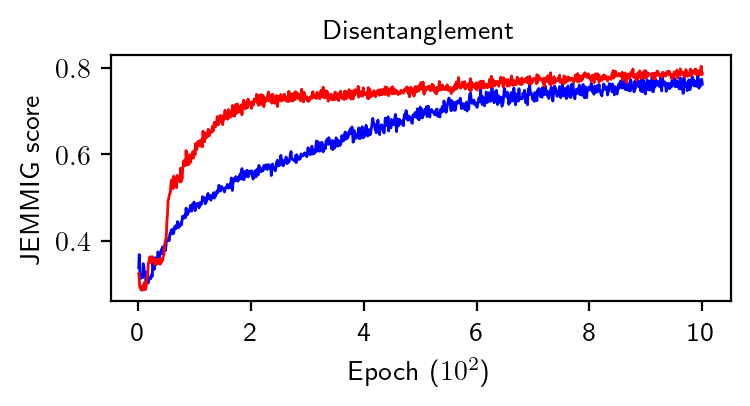

In [10]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


_, ax = plt.subplots(figsize=(10 / 2.5, 4 / 2.5), dpi=200)
out_dir = Path("results/disent_paper")
hist_def = np.loadtxt(out_dir / f"{9}_{False}")
hist_kgi = np.loadtxt(out_dir / f"{0}_{True}")
ax.plot(np.arange(1, 1000 + 1, 1), moving_ave(hist_def, 1), label="No KGI", lw=1, c='b')
ax.plot(np.arange(1, 1000 + 1, 1), moving_ave(hist_kgi, 1), label="KGI", lw=1, c='r')
ax.set_xticks([0, 200, 400, 600, 800, 1000],
              [0, 2, 4, 6, 8, 10])
ax.set_ylabel("JEMMIG score")
ax.set_xlabel("Epoch ($10^2$)")
ax.set_title("Disentanglement", fontsize=10)

### Visualize latent

You need the pretrained model weights to visualize the latent. Please download them from [here](https://drive.google.com/file/d/1VA9MR9kVto3H80vlSMoxWxn6jKwWAiRR/view?usp=sharing).

In [11]:
# read all data
data_path = os.path.join("datasets/xy.npz")
data_zip = np.load(data_path)
data = torch.from_numpy(data_zip['imgs']).reshape(1089, -1)

In [12]:
def get_latent(path):
    """ load model and compute latent """
    model = VAE(2)
    model.load_state_dict(torch.load(path))
    model.eval()
    with torch.no_grad():
        return model.encode(data)[0]


xy_def = get_latent("results/disent_models/models_9_False.pt")
xy_kgi = get_latent("results/disent_models/models_0_True.pt")

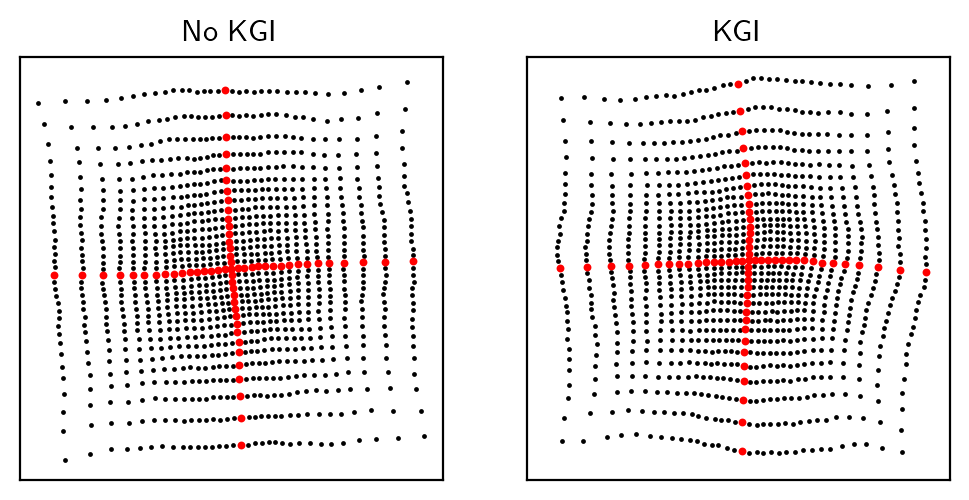

In [13]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(6, 3))
axes[0].scatter(xy_def[:, 0], xy_def[:, 1], s=3, c='k', lw=0)
axes[0].scatter(xy_def[:, 0].reshape(33, 33)[16, :], xy_def[:, 1].reshape(33, 33)[16, :], s=8, c='r', lw=0)
axes[0].scatter(xy_def[:, 0].reshape(33, 33)[:, 16], xy_def[:, 1].reshape(33, 33)[:, 16], s=8, c='r', lw=0)
axes[0].set_aspect(1)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].scatter(xy_kgi[:, 0], xy_kgi[:, 1], s=3, c='k', lw=0)
axes[1].scatter(xy_kgi[:, 0].reshape(33, 33)[16, :], xy_kgi[:, 1].reshape(33, 33)[16, :], s=8, c='r', lw=0)
axes[1].scatter(xy_kgi[:, 0].reshape(33, 33)[:, 16], xy_kgi[:, 1].reshape(33, 33)[:, 16], s=8, c='r', lw=0)
axes[1].set_aspect(1)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[0].set_xlim(-2.5, 2.5)
axes[0].set_ylim(-2.5, 2.5)
axes[1].set_xlim(-2.5, 2.5)
axes[1].set_ylim(-2.5, 2.5)
axes[0].set_title("No KGI", fontsize=11)
axes[1].set_title("KGI", fontsize=11)
plt.savefig("figs/disent_latent.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()